In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Hyperparameters
BATCH_SIZE = 32
EPOCHS = 30
LEARNING_RATE = 0.001
DATA_PATH = '../../data/1200_processed_images_balanced.npy'
SEED = 42

In [2]:

# Load your dataset from .npy file
class ImageDataset(Dataset):
    def __init__(self, npy_file):
        self.data = np.load(npy_file)  # Assuming shape (1200, 256, 256)
        self.data = self.data / 255.0  # Normalize to [0, 1]
        self.data = np.expand_dims(self.data, axis=1)  # Add channel dimension: (1200, 1, 256, 256)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32)

# Define a simple autoencoder
class SimpleAutoencoder(nn.Module):
    def __init__(self):
        super(SimpleAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # Output: (16, 128, 128)
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), # Output: (32, 64, 64)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # Output: (64, 32, 32)
            nn.ReLU(),
        )
        
        # Bottleneck to reduce feature size
        self.bottleneck = nn.Sequential(
            nn.Flatten(),  # Flatten (64, 32, 32) -> (64 * 32 * 32)
            nn.Linear(64 * 32 * 32, 256),  # Fully connected: reduce to 256 features
            nn.ReLU(),
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(256, 64 * 32 * 32),  # Expand back for decoder
            nn.ReLU(),
            nn.Unflatten(1, (64, 32, 32)),  # Reshape back to (64, 32, 32)
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1), # Output: (32, 64, 64)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1), # Output: (16, 128, 128)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # Output: (1, 256, 256)
            nn.Sigmoid()  # To get output in [0, 1]
        )

    def forward(self, x):
        encoded = self.encoder(x)
        encoded = self.bottleneck(encoded)  # Apply bottleneck
        decoded = self.decoder(encoded)
        return decoded
    
    def encode(self, x):
        """Pass the image through the encoder and bottleneck only."""
        with torch.no_grad():
            encoded = self.encoder(x)
            encoded = self.bottleneck(encoded)
        return encoded


def display_images(original_image, encoded_image):
    plt.figure(figsize=(10, 5))

    # Plot the original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title('Original')
    plt.axis('off')

    # Plot the encoded image
    plt.subplot(1, 2, 2)
    plt.imshow(encoded_image, cmap='gray')
    plt.title('Encoded')
    plt.axis('off')

    # Show the plots
    plt.tight_layout()  # Adjust layout for better fit
    plt.show()

In [3]:
# Dataset and DataLoader
dataset = ImageDataset(DATA_PATH)

# Split the dataset into train and test sets
train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size  # Remaining 20% for testing
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Model, Loss, Optimizer
model = SimpleAutoencoder()
criterion = nn.MSELoss()  # Loss function for reconstruction
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Save loss values
train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    model.train()
    running_loss = 0.0
    for images in train_loader:
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)  # Compare output with input
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)  # Save training loss
    print(f"Training Loss: {train_loss:.4f}")
    
    # Validation loop
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for images in test_loader:
            images = images.to(device)
            outputs = model(images)
            loss = criterion(outputs, images)
            test_loss += loss.item()
    
    val_loss = test_loss / len(test_loader)
    val_losses.append(val_loss)  # Save validation loss
    print(f"Validation Loss: {val_loss:.4f}")

# Save the trained model
torch.save(model.state_dict(), 'autoencoder.pth')
print("Model saved as autoencoder.pth")

# Save the loss data
loss_data = {"train_loss": train_losses, "val_loss": val_losses}
torch.save(loss_data, 'loss_data.pth')
print("Loss data saved as loss_data.pth")

Epoch 1/30
Training Loss: 0.0942
Validation Loss: 0.0200
Epoch 2/30
Training Loss: 0.0183
Validation Loss: 0.0179
Epoch 3/30
Training Loss: 0.0124
Validation Loss: 0.0097
Epoch 4/30
Training Loss: 0.0078
Validation Loss: 0.0067
Epoch 5/30
Training Loss: 0.0058
Validation Loss: 0.0057
Epoch 6/30
Training Loss: 0.0052
Validation Loss: 0.0054
Epoch 7/30
Training Loss: 0.0050
Validation Loss: 0.0053
Epoch 8/30
Training Loss: 0.0049
Validation Loss: 0.0052
Epoch 9/30
Training Loss: 0.0048
Validation Loss: 0.0051
Epoch 10/30
Training Loss: 0.0047
Validation Loss: 0.0049
Epoch 11/30
Training Loss: 0.0044
Validation Loss: 0.0046
Epoch 12/30
Training Loss: 0.0042
Validation Loss: 0.0044
Epoch 13/30
Training Loss: 0.0041
Validation Loss: 0.0043
Epoch 14/30
Training Loss: 0.0039
Validation Loss: 0.0042
Epoch 15/30
Training Loss: 0.0038
Validation Loss: 0.0041
Epoch 16/30
Training Loss: 0.0038
Validation Loss: 0.0041
Epoch 17/30
Training Loss: 0.0037
Validation Loss: 0.0040
Epoch 18/30
Training Lo

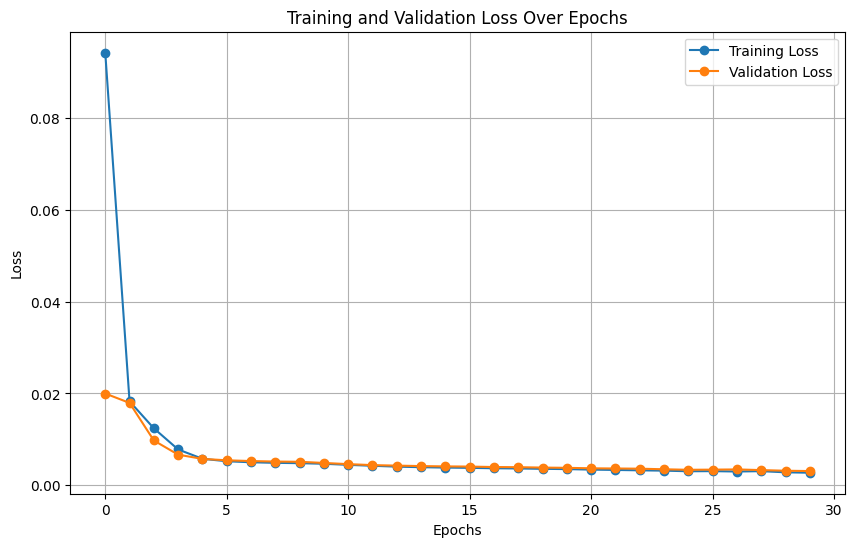

In [4]:
import matplotlib.pyplot as plt

# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


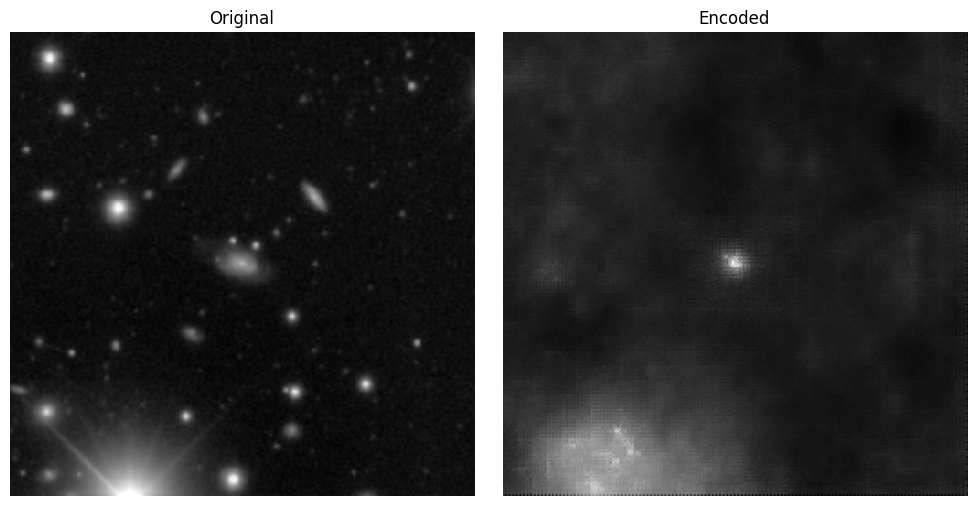

In [36]:
model.eval()

with torch.inference_mode():
    for i in range(1):
        initial = test_dataset[i]
        after_encoder = model.encoder(test_dataset[i])
        after_bottleneck = model.bottleneck(torch.unsqueeze(after_encoder, dim=0))
        decoded = model.decoder(after_bottleneck)
        
        
        initial = np.array(initial)[0]
        decoded = np.array(decoded)[0][0]
        display_images(initial, decoded)

In [44]:
images = np.load(DATA_PATH)
images = images / 255.0
images = np.expand_dims(images, axis=1)
images = torch.tensor(images, dtype=torch.float32)

images.shape, images.max()

(torch.Size([1200, 1, 256, 256]), tensor(1.))

In [ ]:
model.eval()
with torch.inference_mode():
    encoded = model.bottleneck(model.encoder(images))
encoded = encoded.numpy()
encoded.shape

torch.Size([1200, 256])

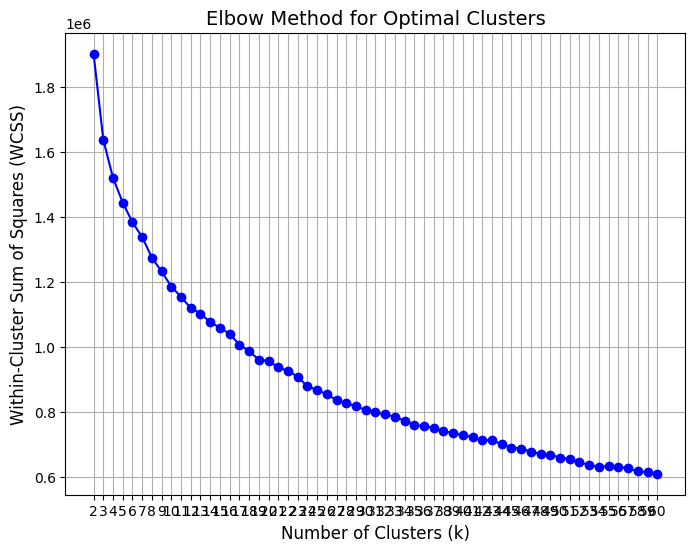

In [52]:
max_clusters = 60  # Maximum number of clusters to try
wcss = []  # List to store WCSS values

# Loop over different numbers of clusters
for n_clusters in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=n_clusters, random_state=SEED, n_init="auto").fit(encoded)
    wcss.append(kmeans.inertia_)  # Save the WCSS (inertia)

# Plot the elbow plot
plt.figure(figsize=(8, 6))
plt.plot(range(2, max_clusters + 1), wcss, marker='o', linestyle='-', color='b')
plt.title("Elbow Method for Optimal Clusters", fontsize=14)
plt.xlabel("Number of Clusters (k)", fontsize=12)
plt.ylabel("Within-Cluster Sum of Squares (WCSS)", fontsize=12)
plt.xticks(range(2, max_clusters + 1))  # Ensure all k values are marked
plt.grid(True)
plt.show()
